In [115]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
import re
from tensorflow import keras
#from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import  tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
#from gensim.models import KeyedVectors
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
tf.compat.v1.disable_v2_behavior()

In [116]:
tf.__version__

'2.4.0'

In [117]:
keras.__version__

'2.4.0'

In [118]:
# Import test set
test_x_df = pd.read_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_x.csv' )
test_x = test_x_df.to_numpy()
test_y = pd.read_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_y.csv').to_numpy()
# test_his_vec = pd.read_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_his_vec.csv').to_numpy()
test_his_vec = np.load('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_his_vec.npy')
# test_chef_vec = pd.read_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_chef_vec.csv').to_numpy()
test_chef_vec = np.load('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_chef_vec.npy')
# read test_x_vital.npy
test_x_vital = np.load('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_x_vital.npy')

In [119]:
# print the shape of the test set
print(test_x.shape)
print(test_y.shape)
print(test_his_vec.shape)
print(test_chef_vec.shape)
print(test_x_vital.shape)

(33835, 18)
(33835, 1)
(33835, 5)
(33835, 5)
(33835, 3, 6)


In [120]:
test_x_df.head()

,gender,race,arrival_transport,nights,hours,admission_hour,admission_day,admission_day_of_week,temperature_triage,heartrate_triage,resprate_triage,o2sat_triage,sbp_triage,dbp_triage,pain_triage,acuity,pain_vitals,count_vital
0,F,BLACK,AMBULANCE,0,1.6,11,16,6,98.0,128.0,16.0,96.0,149.0,100.0,0.0,2.0,0.0,11
1,F,WHITE,WALK IN,0,6.3,15,3,0,97.7,109.0,16.0,96.0,108.0,70.0,0.0,2.0,0.0,4
2,F,WHITE,AMBULANCE,0,4.1,9,28,6,97.9,90.0,16.0,100.0,133.0,86.0,0.0,3.0,0.0,1
3,F,WHITE,AMBULANCE,0,10.9,0,10,2,99.1,66.0,16.0,96.0,141.0,86.0,8.0,2.0,4.0,5
4,F,BLACK,AMBULANCE,0,8.5,12,9,2,97.3,72.0,20.0,100.0,164.0,85.0,8.0,2.0,1.0,5


In [121]:
# Preprocess the test set
num_attr = test_x_df.select_dtypes(include=['float64', 'int64']).columns
cat_attr = test_x_df.select_dtypes(include=['O']).columns
# remove disposition, chiefcomplaint, vital_sign, pre_icd_code in cat_attr
trans_pip = ColumnTransformer([
    ("num",StandardScaler(), num_attr),
    ("cat",OneHotEncoder(),cat_attr)
],remainder='passthrough')

In [122]:
test_x = trans_pip.fit_transform(test_x_df)

feature_names = list(trans_pip.get_feature_names_out())
feature_names

['num__nights',
 'num__hours',
 'num__admission_hour',
 'num__admission_day',
 'num__admission_day_of_week',
 'num__temperature_triage',
 'num__heartrate_triage',
 'num__resprate_triage',
 'num__o2sat_triage',
 'num__sbp_triage',
 'num__dbp_triage',
 'num__pain_triage',
 'num__acuity',
 'num__pain_vitals',
 'num__count_vital',
 'cat__gender_F',
 'cat__gender_M',
 'cat__race_ASIAN',
 'cat__race_BLACK',
 'cat__race_LATINO',
 'cat__race_OTHER',
 'cat__race_WHITE',
 'cat__arrival_transport_AMBULANCE',
 'cat__arrival_transport_HELICOPTER',
 'cat__arrival_transport_OTHER',
 'cat__arrival_transport_UNKNOWN',
 'cat__arrival_transport_WALK IN']

In [123]:
feature_names.extend(['his_icd_1','his_icd_2','his_icd_3','his_icd_4','his_icd_5','chief_1','chief_2','chief_3','chief_4','chief_5'])

In [124]:
# load the model
load_model = keras.models.load_model('model/mortality_NN.h5')

In [125]:
load_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 5, 200)       40400       input_6[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5, 200)       656600      input_7[0][0]                    
____________________________________________________________________________________________

In [126]:
y_test_pred = load_model.predict(x=[test_x,test_his_vec,test_chef_vec, test_x_vital])

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [127]:
y_pred_test_class = np.where(y_test_pred> 0.001, 1, 0)

In [128]:
from sklearn.metrics import balanced_accuracy_score, classification_report
print(classification_report(test_y, y_pred_test_class.round()))
# balanced accuracy
print('balanced accuracy: ', balanced_accuracy_score(test_y, y_pred_test_class.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33798
           1       0.50      0.11      0.18        37

    accuracy                           1.00     33835
   macro avg       0.75      0.55      0.59     33835
weighted avg       1.00      1.00      1.00     33835

balanced accuracy:  0.5539948789549358


# SHAP

In [129]:
import shap
explainer = shap.DeepExplainer(load_model, [test_x[:1000],test_his_vec[:1000],test_chef_vec[:1000], test_x_vital[:1000]])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [142]:
test_x.shape

(33835, 27)

In [130]:
shap_values = explainer.shap_values([test_x[:1000],test_his_vec[:1000],test_chef_vec[:1000], test_x_vital[:1000]])

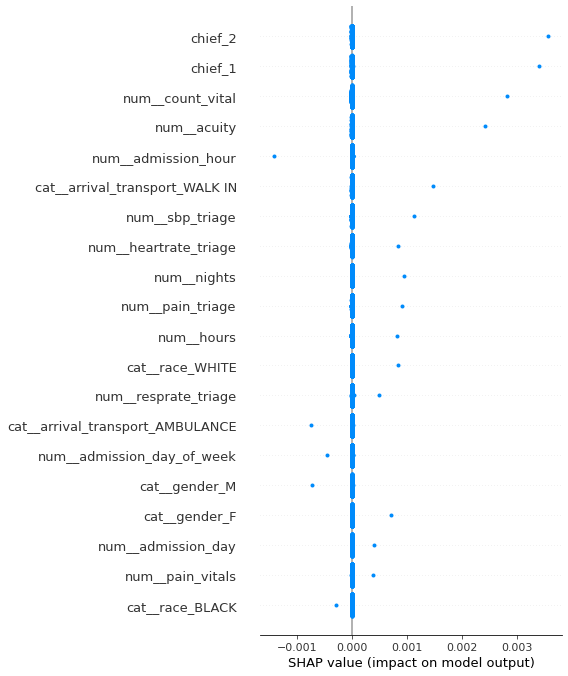

In [131]:
shap.summary_plot(np.concatenate([shap_values[0][0], shap_values[0][1], shap_values[0][2]], axis=1), feature_names = feature_names, max_display = 20)

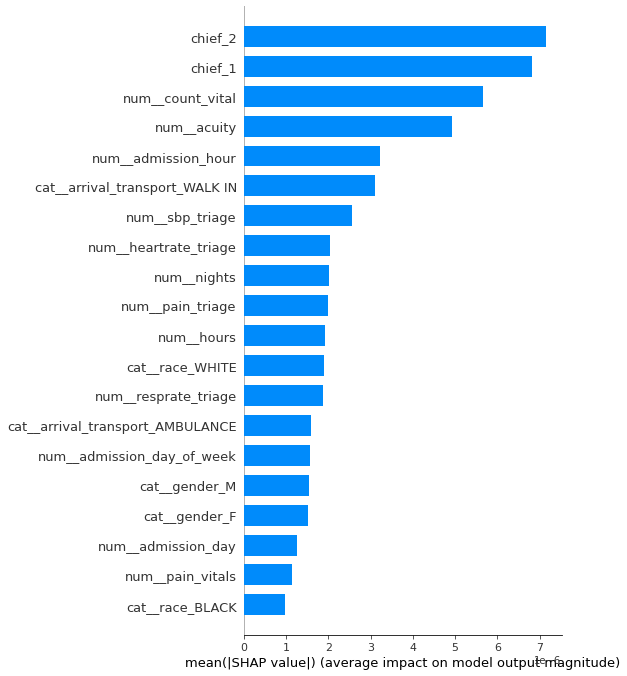

In [132]:
shap.summary_plot(np.concatenate([shap_values[0][0], shap_values[0][1], shap_values[0][2]], axis=1), feature_names = feature_names, max_display = 20, plot_type="bar")

In [139]:
# check row in test_y array that is 1 i
for i in range(0, len(y_pred_test_class)):
    if y_pred_test_class[i] == 1:
        print(i)

423
2784
7180
11023
16804
32147
32191
32941


In [134]:
y_pred_test_class_0 = np.where(load_model.predict(x=[test_x[0:1],test_his_vec[0:1],test_chef_vec[0:1], test_x_vital[0:1]])> 0.000001, 1, 0)
print(y_pred_test_class_0)
shap_values_0 = explainer.shap_values([test_x[0:1], test_his_vec[0:1], test_chef_vec[0:1], test_x_vital[0:1]])
shap.force_plot(explainer.expected_value[0], np.concatenate([shap_values_0[0][0], shap_values_0[0][1], shap_values_0[0][2]], axis=1), feature_names = feature_names)

[[0]]


In [141]:
y_pred_test_class_423 = np.where(load_model.predict(x=[test_x[423:424],test_his_vec[423:424],test_chef_vec[423:424], test_x_vital[423:424]])> 0.000001, 1, 0)
print(y_pred_test_class_423)
shap_values_423 = explainer.shap_values([test_x[423:424], test_his_vec[423:424], test_chef_vec[423:424], test_x_vital[423:424]])
shap.force_plot(explainer.expected_value[0], np.concatenate([shap_values_423[0][0], shap_values_423[0][1], shap_values_423[0][2]], axis=1), feature_names = feature_names)

[[1]]


In [136]:
y_pred_test_class_2784 = np.where(load_model.predict(x=[test_x[2784:2785],test_his_vec[2784:2785],test_chef_vec[2784:2785], test_x_vital[2784:2785]])> 0.000001, 1, 0)
print(y_pred_test_class_2784)
# force plot for the 2784th patient
shap_values2784 = explainer.shap_values([test_x[2784:2785], test_his_vec[2784:2785], test_chef_vec[2784:2785], test_x_vital[2784:2785]])
shap.force_plot(explainer.expected_value[0], np.concatenate([shap_values2784[0][0], shap_values2784[0][1], shap_values2784[0][2]], axis=1), feature_names = feature_names)


[[1]]
